### Considerations and ideas for working with 3D model and vertical observations

#### Summary of qustionnaire ~40 answers

- People use sigma-layers (some use Mike Wave but I guess it also work with sigma)
- Most use fixed profile location in time
- Some use Matlab and excel but most use python and Mike Zero Probably P or M in combination with Mike Zero
- Most people interpolate model depth to exact obs pos. However, ~1/3 binned the obs to model cells (with or without aggregate)
- Clear, ready to use visualizations are highly valued: observed vs modelled vertical profiles
- Vertical profile analysis is a key gap: e.g. depth range stats, and easier profile to profile comparisons.  
- Advanced diagnostic plots are requested: e.g. Hovmöller diagrams
- Users have example plots and scripts

**What does this mean for Modelskill dev**:

1. Focus on sigma-z layers
2. Start with x,y fixed profiles
3. Options to interpolate or bin observations
4. Need dedicated vertical plots
5. Vertical profiles stats, e.g. vertical_grid_stats


#### Features needed for minimal version

- Support vertical observations with fixed position and depth coordinates. Time coordinate should support non-equidistant timsteps.
- Match 3D sigma model to these observations with binning and interpolation. Get a comparerer.
- Calculate statistics on vertical grids (e.g. rmse with depth)
- Slice Comparer in vertical (results similar as comaprer with pointObs)
- Aggregate Comparerer in vertical (results similar as comaprer with pointObs)
- Plots

#### Usefull plots

**Timeseries of all depth**

As below but raw data not only mod-obs pairs. As timeseries plots today but all depth
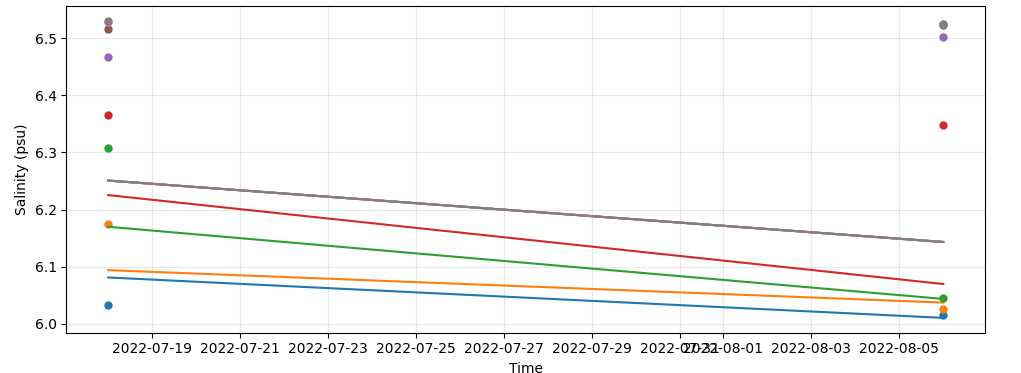


**Profiles of all times**

So, this is a selected time, could include several profiles  
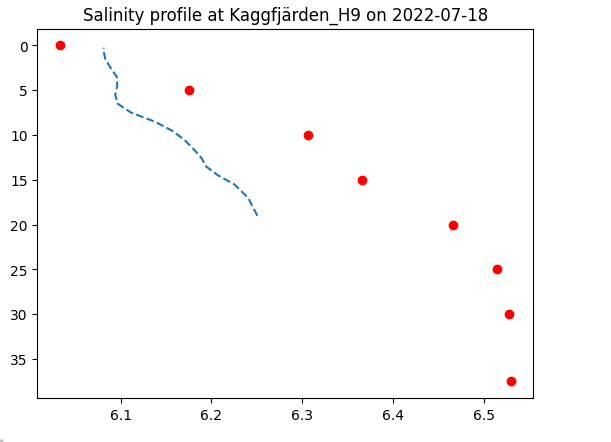

**Havmöller plots**

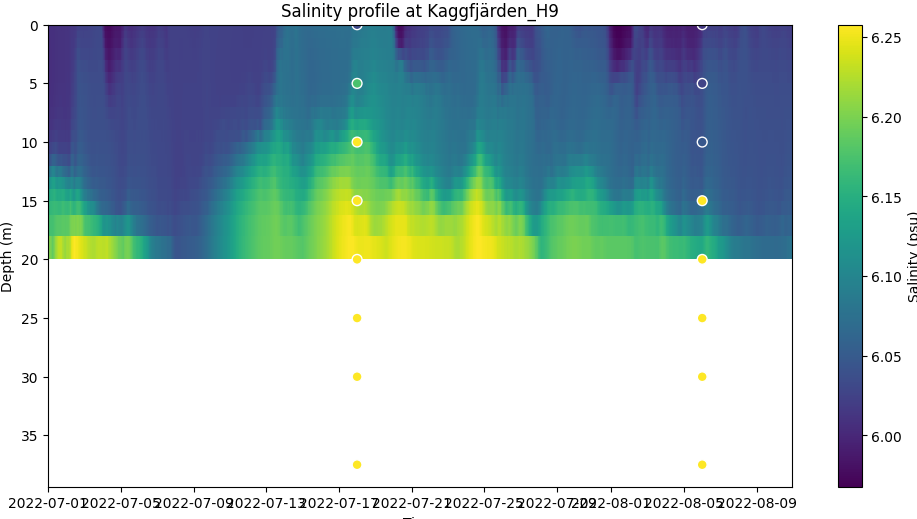

**Vertical statistics**
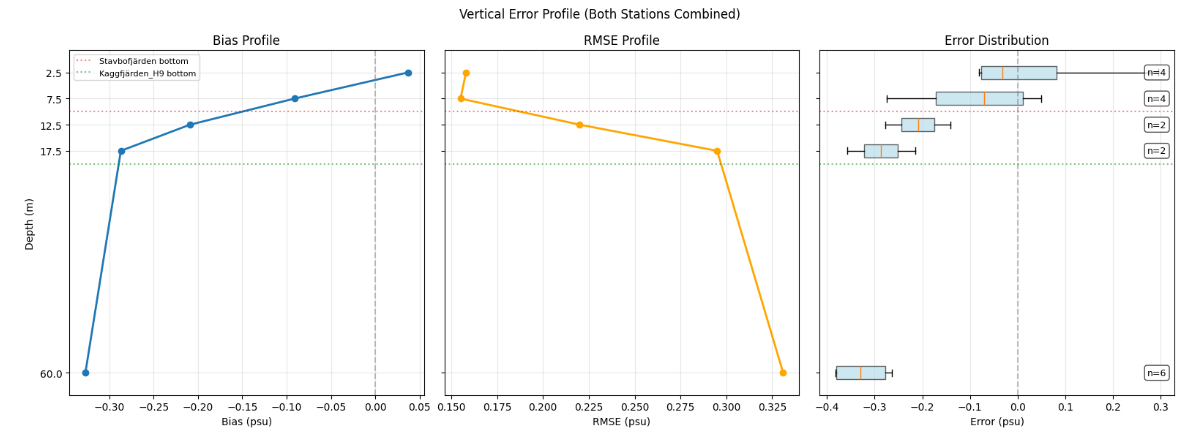

#### Implementation ideas

**Proposal**

1. VerticalObservation class  
    - Stores z coordinate as dimension, x,y as attributes and time
    - Distinguishable from track (x,y coordinates) or point (single x,y,z coordinate)
    - Format for dataframe and dfs
    - Create vertical grid out of all available z
2. Support sigma-levels
    - Need to consider time when matching mod-obs in depth
    - Need layer boundaries in mikeio calc_zf()

3. Matching for verticalObservation needs implementation
    - interpolate mod to obs 
    - or bin obs in model cells
4. from_matched()
    - Consider dataframe structure for creating vertical obs. Is it enough with a column z? Create vertical grid containing all z.

5. Same comparer as today but add support for VerticalObservation
    - plots same as today for all depth (ignoring z coordinate)
    - to_dataframe() include z
    - sel/slice on vertical coordinate
    - vertical_skill(binds, metric) > SkillProfile (1D in z)
6. SkillProfile 
    - xr.Dataset with dim z, with .plot()  or a 
        - producing bias/RMSE vs depth
        - Havmöller? or depth/time (would require raw model)
        - model and obs on depth (Profiles) (would require raw model)

Pros: 
- Reduced code modification/additions. 
- Use same plots etc. as today. 
- Need to add vertical_skill and SkillProfile  

Cons: 
- The comparer plots we have today does not consider vertical. 
- Most plots above will not be supported (maybe only plots in SkillProfile)
- No easy way to aggregate depth

Questions: Do we need new 3dModel class?


Example:
```Python

# ==============================================
# Match mod and obs
# ==============================================

# Create vertical observations
vobs1 = VerticalObservation(df_1, x=, y=)  
vobs2 = VerticalObservation(df_2, x=, y=) #or dfs1?

# Probably need sigma layers support...current model have support for Dfsu3D, Dfsu2H...check this**  
mr = DfsuModelResult(ds, name="HD3D Salinity")   

# Match observations and model results (detects that we use vertical observations)
cmp = match([vobs1, vobs2], mr) 

# ==============================================
# Slicing comparer
# ==============================================

# Select depth levels from comparer (notice that we have z-coordinates in observations)
cmp_sfr = cmp.sel(zmin=0, zmax=15)
cmp_z30_40 = cmp.sel(z=[30, 40])

# or select from area as with other comparers
cmp_sfr_area = cmp.sel(area=(650000, 6.52e6, 668000, 6.54e6))

# or with time slicing
cmp_sfr_time = vcmp.sel(time=slice("2022-07-01", "2022-08-01"))

# ==============================================
# Comparer plots
# ==============================================
# All plots we have today in comparer can be applied to vertical data
# However, no vertical information without slicing the comparer.
# NOTE: most plots today deal with time, no way of plotting time,depth (e.g. havmöller)
v.plot.timeseres()
cmp.plot.box()
...

# Vertical info
cmp_20_30 = cmp.sel(z=[30, 40])
cmp_30_40 = cmp.sel(z=[30, 40])
cmp_30_40.plot.bar()
cmp_20_30.plot.bar()

# ==============================================
# Skill
# ==============================================
# Same as today and same problem as above.
# Comaprer needs to be sliced to get vertical info
cmp_20_30.skill()
cmp.skill()

# ==============================================
# Vertical skill
# ==============================================
sp = cmp.vertical_skill() > SkillProfile

sp.metrics
['n', 'bias', 'rmse', 'urmse', 'mae', 'cc', 'si', 'r2']

#selection
sp.sel(z = [50:100])

# plots
sp.plot.profile() # bias, rmse... plots as seen above (y-axis = depth, x-axis=value)
...

```
**Option:**   
Add VerticalAccessor on Comparer to allow vertical aggregation and dedicated profile plots** 

Reason:
- Supports more plots
- Supports aggregation 
- no need for vertical_skill() on comparer. It is now on vertical

VerticalAccessor:
- vertical.mean(zmin, zmax) > returns collapsed comparer. Ordinary workflow after that
- vertical.slice(depth) > returns collapsed comparer. Ordinary workflow after that
    - Equivalent to creating per‑depth DataFrames manually today.
- vertical.skill(mertrics, ) > SkillProfile  similar to SkillGrid with xarray dataset and z coord and .plot() for lines 
    - Analogous to Comparer.skill() → SkillTable, Comparer.gridded_skill() → SkillGrid (x–y grid)
- vertical.skill(bins|bin_size) (as gridded_skill() but for z)
    - Analogous to spatial binning (gridded_skill) but in 1D (depth).
- vertical.plot.profile() - value vs depth for mod and obs
    - Just like plot.timeseries() but operating in depth space.

Example:
```Python
# Examples:
cmp0_15 = cmp.vertical.mean(zmin=0, zmax=15) #(max, min as well)
cmp0_15.plot.timeseries() #no depth coordinate anymore
cmp0_15.skill()

cmp5m = cmp.vertical.slice(depth=5)
cmp5m.plot.timeseries() 

sp = cmp.vertical.skill(metrics=["rmse", "bias"], bin_size=) #options to bin data
sp.rmse.plot()        # RMSE vs depth
sp.bias.plot()

cmp.vertical.plot.profile(time="2023-07-15T12:00")

cmp.vertical.plot.skill(metric="rmse")


class Comparer:
    ...
    @property
    def vertical(self):
        return VerticalAccessor(self)


class VerticalAccessor:
    def __init__(self, cmp):
        self._cmp = cmp

    def mean(self, zmin, zmax):
        ds = self._cmp.data
        ds2 = _vertical_mean(ds, zmin, zmax)  # returns time-series dataset
        return Comparer.from_matched_dataset(ds2)  # uses existing API

    def slice(self, depth):
        ds = self._cmp.data
        ds2 = _vertical_interpolate(ds, depth)
        return Comparer.from_matched_dataset(ds2)

    def skill(self, metrics=None, bins=None):
        ds = self._cmp.data
        if bins:
            dsb = _vertical_bin(ds, bins)
        else:
            dsb = ds
        sk = _compute_skill_per_depth(dsb, metrics)
        return SkillProfile(sk)

    @property
    def plot(self):
        return VerticalPlotAccessor(self._cmp)

```